<a href="https://colab.research.google.com/github/brenorc110/PythonCodes/blob/master/cnn-keras-mnist-notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
#base de dados para treinamento
from keras.datasets import mnist
#Utilitario de montar camadas: 
from keras.models import Sequential
#Classe para criacao das camadas finais (densamente conectadas)
from keras.layers import Dense
#Normalização: Impedir overfitting e normalizar daods em vetor.
from keras.layers import Dropout
from keras.layers import Flatten
#Componente que raliza a convolucao
from keras.layers.convolutional import Conv2D
#Realiza a fase de pooling, retirar amostras do mapa de features
from keras.layers.convolutional import MaxPooling2D
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import np_utils
import cv2
import os

from keras import backend as K

#Usando a ordem dos dados da imagem do Theano (framework): (canais, altura, largura), TensorFlow usa (alt, larg, canais). Serão usadas imgs 28x28 px.
#K.tensorflow_backend.set_image_dim_ordering('th')
K.set_image_data_format('channels_first')

%matplotlib inline

seed = 7
np.random.seed(seed)

Using TensorFlow backend.


In [2]:
def get_available_gpus():
    if K.tensorflow_backend._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        K.tensorflow_backend._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in K.tensorflow_backend._LOCAL_DEVICES if 'device:gpu' in x.lower()]

def load_data():
    #Importando as features de treino e de teste do Mnist: 
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    #Redimensionando os objetos do dataset (Mnist), de treino, e depois, de teste:
    #(60000 imgs, 1 canal cinza, 28px, 28px)
    x_train = x_train.reshape(x_train.shape[0], 1, 28, 28).astype('float32')
    
    x_test = x_test.reshape(x_test.shape[0], 1, 28, 28).astype('float32')
    # Passa os valores para um intervalo de 0 a 1, divindindo-os por 255
    x_train = x_train / 255
    x_test = x_test / 255
    #Passando para valores categoricos (matriz).
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    print(x_train.shape)
    return x_train, y_train, x_test, y_test

In [3]:
x_train, y_train, x_test, y_test = load_data()
num_classes = y_test.shape[1] # Testa quantas camadas criadas.

# O model será exportado para este arquivo
filename='mnistneuralnet.h5'

def model():
    #Rede neural em si:
    model = Sequential()
    #1a camada: 30 feature maps, varrerá numa janela 5x5, imagens no padrão já mencionado, e funcao de ativacao relu.
    model.add(Conv2D(30, (5, 5), input_shape=(1, 28, 28), activation='relu'))
    #2a camada: Pooling, retira a amostra, no caso de 2x2.
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(15, (3, 3), input_shape=(1, 28, 28), activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    #3a camada: Regularizacao (Desliga neuronios aleatoriamente para vitar overfitting).
    model.add(Dropout(0.2))
    #4a camada: Fletar, transformar a camada com os dados em matriz.
    model.add(Flatten())
    #Camada simples com 128 neurônios
    model.add(Dense(128, activation='relu'))

    model.add(Dense(64, activation='relu'))

    model.add(Dense(32, activation='relu'))
    #Camada final: junta dados e classificacao final.
    model.add(Dense(num_classes, activation='softmax', name='predict'))
    #Para consolidar a rede, de fato. Funcao de loss (perda) calcula os erros. optimizer poderia ser gradient descent
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

11493376/11490434 [==============================] - 2s 0us/step
(60000, 1, 28, 28)


In [4]:
K.tensorflow_backend._get_available_gpus = get_available_gpus

model = model()
model.summary()

# Verifica se já existe um modelo treinado e exportado para um arquivo .h5.
# Um novo modelo será treinado, caso este arquivo não exista.
if not os.path.exists('./{}'.format(filename) ):
    model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=200)
    model.save_weights(filename)
else:
    # carrega um modelo previamente treinado
    model.load_weights('./{}'.format(filename) )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 24, 24)        780       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 12, 12)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 10, 10)        4065      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 5, 5)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 5, 5)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 375)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)              

In [5]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("\nacc: %.2f%%" % (scores[1]*100))


acc: 99.11%


2  com confiança de  98.88%


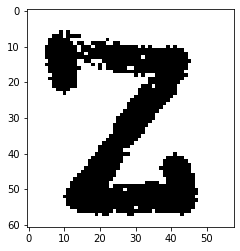

In [16]:
img_pred = cv2.imread("Z72.png", 0)
plt.imshow(img_pred, cmap='gray')

if img_pred.shape != [28,28]:
    img2 = cv2.resize(img_pred, (28, 28))
    img_pred = img2.reshape(28, 28, -1)
else:
    img_pred = img_pred.reshape(28, 28, -1)


img_pred = img_pred.reshape(1, 1, 28, 28).astype('float32')

img_pred = img_pred/255.0



pred = model.predict_classes(img_pred)
pred_proba = model.predict_proba(img_pred)
pred_proba = "%.2f%%" % (pred_proba[0][pred]*100)
print(pred[0], " com confiança de ", pred_proba)
